<a href="https://colab.research.google.com/github/dheerajreddy3108/Plant-and-weed-detection/blob/main/Plant_and_weed_detection_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detection of different kinds of weed plants are grown together with other plants in the farm using Object Detection**

---






The notebook is formatted in the following way:



*   Loading the Data
*   Data Preprocessing
*   Data Visualization
*   Building the model
*   Model Optimization
*   Prediction and Visualization of test Images











In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### The first step in google colab notebook is to mount the drive to the notebook so that the data can be accessed.







In [2]:
import os
os.chdir('/content/gdrive/My Drive/agri_data')
os.getcwd()

'/content/gdrive/My Drive/agri_data'

We change the directory to the location where image data is availabe

In [18]:
path = '/content/gdrive/My Drive/agri_data'
files = os.listdir(path)
print(files)

['data_file.csv', 'data']


As we can see the type of files in the data directory are a .csv file that contians information on image name and the bounding box coordinates that are preprocessed using data preprocessing notebook


## **Import the libraries**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

# **Data Preprocessing**

#####A class is defined to take the shape and data directory as input and load the images along with the bounding boexs of the plants and different types pf weed. In the end we get the data seperated into train and test for model training and testing respectively. 

The reason for the shape being 224 is we are using a pretrained ResNet50 model and the input shape to the resnet model is 224. 

The functioning of the class is described below.

First we initailize all the variables to the default values inside the class. It is because once the class is executed the variables that have scope locally are removed from the memory. One advantage is that the memory can be used in a more dynamic way.

I defined a function to read each image in the given data directory using OpenCV library. OpenCV library by default reads any image in the formal BGR i.e is Blue Green and Red. Before we go to next steps we convert the image to RGB format. Then the image is reshaped to the size that is intialized above. The shape here is (224,244,3). Then the data type of the image array is converted to float because when we normalize the image there is a chance of loosing information. So float is used and  the values of image after normalization is in range 0 to 1.

The label data or annotation file for each image is saved in a text file with the name same as image. Each text file is read and each line inside the text file denotes the class the object(object here can be either plant or weed). For each line the first element represents the class of the object and other denotes the coordinates of the bounding box around the object. The values are read as they are from the annotation file. 

Here **Class 0 indicates the crop plant  and Class 1 denotes various weed plants in the crop.**

In the next step we concat the values to the data_csv file we created with image name and other information that is read in the previous steps.

I created a function called load_data that calls other functions inside it to read and load the data. In the last step of the class we split the data into train and test. The data is split in 80:20 ratio as the data is not so big to choose other ratios.

In [5]:
data_dir = '/content/gdrive/My Drive/agri_data/data'
shape = 224
classes = []

class Data:
    def __init__(self,shape,data_dir):
        self.data = os.listdir(data_dir)
        self.data_csv = 0
        self.image_data = []
        self.y_bbox = []
        self.label_data = []
        self.image_data_files = []
        self.label_data_files = []
        self.labels = []
        self.shape = shape
        self.data_dir = data_dir
        
    def image_preprocessing(self,path):
        image = cv2.imread(path)
        image = cv2.resize(image, (shape,shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.reshape(image,(shape,shape,3))
        image = np.array(image, dtype = 'float32')
        image /= 255.
        return image 
    
    def image_and_label_data(self):
        for data_file in self.data:
            if data_file.split('.')[-1] == 'txt':
                data = open(f'{self.data_dir}/{data_file}', 'r').readline().split()
                
                df = pd.DataFrame()
                df['filename'] = [data_file]
                df['class'] = [float(data[0])]
                df['xmin'] = [float(data[1])]
                df['ymin'] = [float(data[2])]
                df['xmax'] = [float(data[3])]
                df['ymax'] = [float(data[4])]
                self.label_data_files.append(df)
                
        self.data_csv = pd.concat(self.label_data_files)
        for i in list(self.data_csv.columns[2:]):
            self.data_csv[i] = self.data_csv[i].astype(float)
            
    def read_images(self):
        self.image_paths = self.data_csv['filename'].values
        for image in self.image_paths:
            self.image_data.append(self.image_preprocessing(self.data_dir + '/' +image.split('.')[0] + '.jpeg'))
                
    def read_labels(self):
        global classes
        self.classes = self.data_csv['class'].unique().tolist()
        classes = self.classes
        self.label_data = self.data_csv['class'].values
        self.label_data = [self.classes.index(i) for i in self.label_data]
        self.label_data = tf.keras.utils.to_categorical(self.label_data)
        self.label_data = np.array(self.label_data,dtype = 'float32')
    
    def bboxes(self):
        for index, _ in enumerate(self.data_csv["xmin"].values):
            self.y_bbox.append(self.data_csv.iloc[[index]].values[0])
        self.y_bbox = np.array(self.y_bbox, dtype= "float32")
        

        
    def load_data(self):
        self.image_and_label_data()
        self.read_labels()
        self.read_images()
        self.data_csv = self.data_csv.drop('class',axis = 1)
        self.data_csv = self.data_csv.drop('filename',axis=1)
        self.bboxes()
            
        return train_test_split(self.image_data,self.label_data,self.y_bbox,random_state = 43,shuffle=True)
                               
         

The class we defined above is called by passing in Shape and Data Directory 

In [6]:
data = Data(shape,data_dir)
#r = data.read_images()
split = data.load_data()

In [7]:
(X_train, X_test) = split[:2]
(y_train,y_test) = split[2:4]
(y_bbox_train, y_bbox_test) = split[4:]
X_train = np.array(X_train, dtype = 'float32')
X_test = np.array(X_test, dtype = 'float32')

y_bbox_train = np.array(y_bbox_train, dtype ='float32')
y_bbox_test = np.array(y_bbox_test, dtype = 'float32')
y_train = np.array(y_train, dtype = 'float32')
y_test = np.array(y_test, dtype = 'float32')

print(f'X_train of Shape: {X_train.shape}')
print(f'X_test of Shape : {X_test.shape}')
print(f'y_train of Shape : {y_train.shape}')
print(f'y_test of Shape : {y_test.shape}')
print(f'y_bbox_train of Shape: {y_bbox_train.shape}')
print(f'y_bbox_test of Shape: {y_bbox_test.shape}')


X_train of Shape: (975, 224, 224, 3)
X_test of Shape : (325, 224, 224, 3)
y_train of Shape : (975, 2)
y_test of Shape : (325, 2)
y_bbox_train of Shape: (975, 4)
y_bbox_test of Shape: (325, 4)


As it can ne seen from the statistics above that the image is of shee (224,224,3). X_train is of size 975 images and X_test is of size 325. Label data is split into categories. Category 1 for classification of the object into either plant or weed class. The values are saved into y_train and y_test for X_train and X_test respectively. 

y_bbox is a list with the coordinates of each object. It have 4 elements for each label.

In [12]:
class NN():
    def __init__(self, cnn):
        self.model_input_lr = Input(shape=(shape,shape,3))
        self.cnn = cnn(weights = 'imagenet',include_top=False, input_tensor = self.model_input_lr)
        for layer in self.cnn.layers:
            layer.trainable = False
        self.model_build()
    
    
    def model_build(self):
        
        flatten = tf.keras.layers.Flatten()(self.cnn.output)
        x = tf.keras.layers.Dense(1024, activation = "relu", kernel_initializer ="he_normal")(flatten)
        x = tf.keras.layers.Dense(512, activation = "relu", kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.Dense(128, activation = "relu", kernel_initializer = "he_normal")(x)
        output1 = tf.keras.layers.Dense(len(classes), activation = "softmax", name = "classification_lr")(x)
        
        x = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer ="he_normal")(flatten)
        x = tf.keras.layers.Dense(128, activation = "relu", kernel_initializer ="he_normal")(x)
        x = tf.keras.layers.Dense(64, activation = "relu", kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.Dense(32, activation = "relu", kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.Dense(16, activation = "relu", kernel_initializer = "he_normal")(x)
       
        output2 = tf.keras.layers.Dense(4, activation = "sigmoid", name = "boundingbox")(x)
        
        
        self.model = Model(inputs = [self.model_input_lr],outputs=[output1,output2])
        losses = {'classification_lr':'categorical_crossentropy','boundingbox':'mean_squared_error'}
        lossWeights ={'classification_lr' :1., 'boundingbox':1.}
        
        lr_rate= 1e-4
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr_rate,decay_steps=10000,
                                                                     decay_rate=0.9)
        optimizer = tf.keras.optimizers.Adam(lr_rate)

        self.model.compile(optimizer=optimizer,loss =losses,metrics=['accuracy'])
        
        #es = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, mode = 'auto',restore_best_weights = False)
        #mc = ModelCheckpoint(filepath = '/content/gdrive/My Drive/agri_data', monitor = 'val_loss', save_best_only = False,save_weights_only = False, mode = 'auto')
        
        self.model.fit(X_train,y ={'classification_lr':y_train,'boundingbox':y_bbox_train},epochs=100,validation_data=(X_test,{'classification_lr':y_test,'boundingbox':y_bbox_test}),shuffle=True)
        

Here I used a model that is pretrained on imagenet data which is made of 1000 classes for classification. The last layers of the network are not used and only convolutional layers and weights are used. Few custom layers are added to the network according to our model purpose. First few dense layers are added that are common for classification and bounding box regressor. This helps to reduce the number of parameters in the network and reduce computation effort as well. In the end 2 sibling branches are added. One for classification and another for bounding box regressor. 

Loss for each sub-task is to be defined. For classification, I used categorical_crossentropy because we have 2 nodes in the end classification layer. For bounding box regressor I used mean_squared_error.

Mean squared Error is given by:
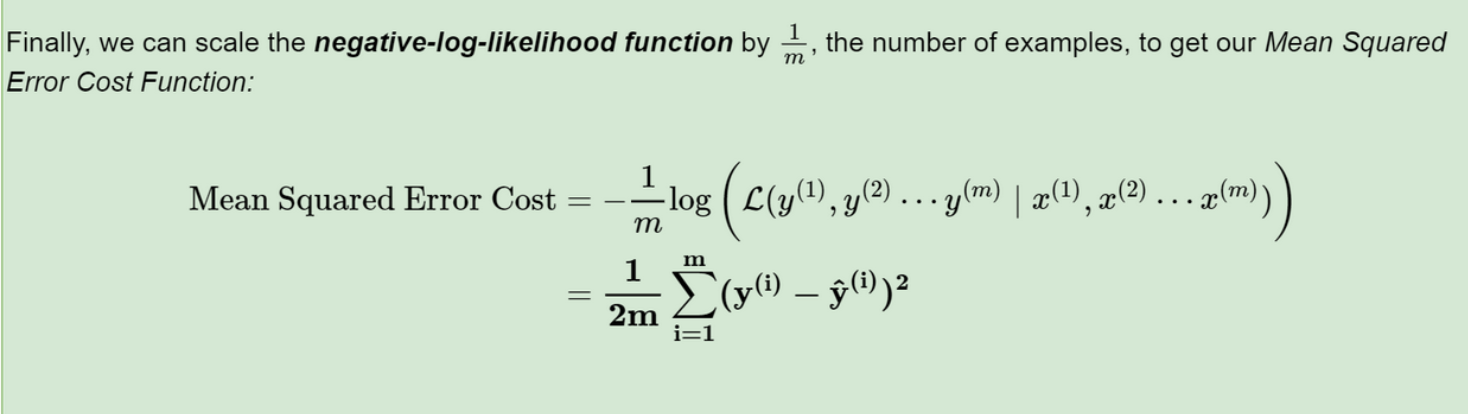



Adam is used as optimizer with learning rate of 1e-4. It is taking time to converge with the learning rate decay steps. So, it is left unused in the model here. The model is trained for 100 epochs.

In [13]:
model = NN(tf.keras.applications.resnet.ResNet50)

Epoch 1/100
31/31 [==============================] - 16s 390ms/step - loss: 0.9528 - classification_lr_loss: 0.9192 - boundingbox_loss: 0.0336 - classification_lr_accuracy: 0.5600 - boundingbox_accuracy: 0.5395 - val_loss: 0.5078 - val_classification_lr_loss: 0.4802 - val_boundingbox_loss: 0.0276 - val_classification_lr_accuracy: 0.8800 - val_boundingbox_accuracy: 0.5323
Epoch 2/100
31/31 [==============================] - 11s 345ms/step - loss: 0.4808 - classification_lr_loss: 0.4562 - boundingbox_loss: 0.0246 - classification_lr_accuracy: 0.7990 - boundingbox_accuracy: 0.5744 - val_loss: 0.5691 - val_classification_lr_loss: 0.5443 - val_boundingbox_loss: 0.0248 - val_classification_lr_accuracy: 0.6800 - val_boundingbox_accuracy: 0.5385
Epoch 3/100
31/31 [==============================] - 11s 345ms/step - loss: 0.3834 - classification_lr_loss: 0.3606 - boundingbox_loss: 0.0228 - classification_lr_accuracy: 0.8431 - boundingbox_accuracy: 0.5990 - val_loss: 0.3359 - val_classification_l

As it can be seen from the output statistics of each epoch that the model is perfoming pretty good in terms of classification of the object into its respective class for both training and validation. The bounding box accuracy is fluctuating around 76%. The model can be improved in terms of the bounding box regressor. 

[[9.9959332e-01 4.0669792e-04]]


(-0.5, 223.5, 223.5, -0.5)

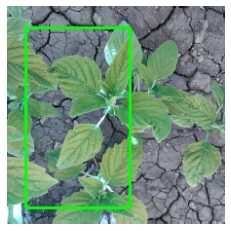

In [16]:
image = cv2.imread("/content/gdrive/My Drive/agri_data/data/agri_0_544.jpeg")
image = cv2.resize(image, (shape, shape))
image_1 = np.reshape(image, (1 ,shape, shape, 3))
pred = model.model.predict(image_1)
print(pred[0])
startX = int(pred[1][0][0] * 224)
startY = int(pred[1][0][1] * 224)
endX =   int(pred[1][0][2] * 224)
endY =   int(pred[1][0][3] * 224)
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
plt.imshow(image)
plt.axis('off')

As it can be seen from the output that the model is 99.95% confident that the detected object is plant and 4e-4 is only the probability for it being weed. The model outcome is true here. And the bounding box is not clearly showing around the entire object. The reason for multiplication with the value of 224 is because the predictions will be within 0 and 1 and we want them to be in the same scale as that of image. So we multiply by the shape dimension.